#  Case Study: Demand Forecasting with XGBoost & Streamlit

## Objective
### Design and implement a lightweight, scalable forecasting solution using machine learning that:

#### Segments products by volatility
#### Trains individualized models per product
#### Forecasts sales for the next 5 weeks
#### Presents results in a user-friendly dashboard

In [3]:
import pandas as pd

# Load your dataset
df = pd.read_csv("Sales_Transactions_Dataset_Weekly.csv")

In [5]:
df.shape

(811, 107)

In [7]:
# Extract weekly sales columns (assumes 'W0' to 'W51' are week columns)
weekly_columns = [col for col in df.columns if col.startswith('W')]
sales_data = df[weekly_columns]

# Compute basic sales statistics
df['Total_Sales'] = sales_data.sum(axis=1)
df['Average_Sales'] = sales_data.mean(axis=1)
df['Sales_StdDev'] = sales_data.std(axis=1)
df['Sales_Min'] = sales_data.min(axis=1)
df['Sales_Max'] = sales_data.max(axis=1)
df['Zero_Weeks'] = (sales_data == 0).sum(axis=1)
df['Non_Zero_Weeks'] = (sales_data != 0).sum(axis=1)

# Create a summary table
profile_summary = df[['Product_Code', 'Total_Sales', 'Average_Sales', 'Sales_StdDev',
                      'Sales_Min', 'Sales_Max', 'Zero_Weeks', 'Non_Zero_Weeks']]

# Display the top few rows
print(profile_summary.head())

  Product_Code  Total_Sales  Average_Sales  Sales_StdDev  Sales_Min  \
0           P1          501       9.634615      3.694346          3   
1           P2          207       3.980769      2.363865          0   
2           P3          452       8.692308      2.920774          3   
3           P4          430       8.269231      3.565166          2   
4           P5          440       8.461538      3.238624          3   

   Sales_Max  Zero_Weeks  Non_Zero_Weeks  
0         21           0              52  
1         10           2              50  
2         14           0              52  
3         19           0              52  
4         18           0              52  


### Visualize Weekly Sales Time Series

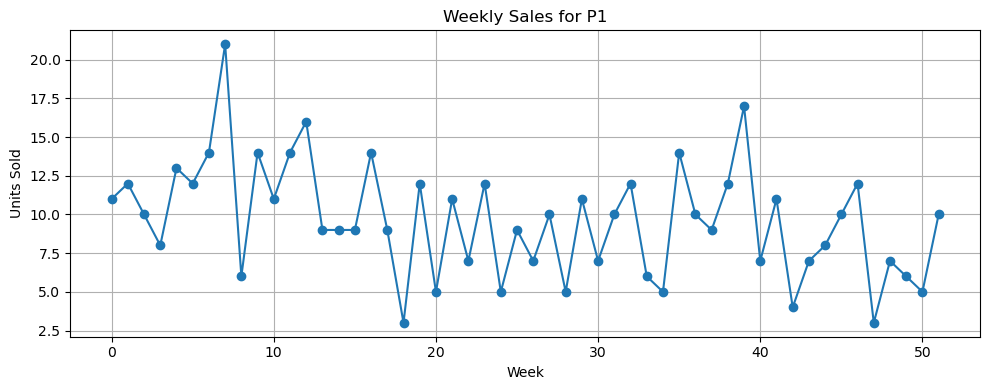

In [38]:
import matplotlib.pyplot as plt

# Function to plot sales time series for a product
def plot_product_sales(df, product_code):
    weekly_columns = [col for col in df.columns if col.startswith('W')]
    product_row = df[df['Product_Code'] == product_code]
    if product_row.empty:
        print(f"Product {product_code} not found.")
        return
    sales = product_row[weekly_columns].values.flatten()
    
    plt.figure(figsize=(10, 4))
    plt.plot(range(len(sales)), sales, marker='o')
    plt.title(f"Weekly Sales for {product_code}")
    plt.xlabel("Week")
    plt.ylabel("Units Sold")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage: replace 'P1' with any product code
plot_product_sales(df, 'P1')

### Segment Products by Volatility

In [41]:
# Segment based on Sales Std Dev (volatility)
df['Volatility_Segment'] = pd.qcut(df['Sales_StdDev'], q=3, labels=['Low', 'Medium', 'High'])

# Count products in each segment
print(df['Volatility_Segment'].value_counts())

# Example: get top 5 high-volatility products
high_vol_products = df[df['Volatility_Segment'] == 'High'].sort_values(by='Sales_StdDev', ascending=False)
print(high_vol_products[['Product_Code', 'Sales_StdDev']].head())

Volatility_Segment
High      271
Low       270
Medium    270
Name: count, dtype: int64
    Product_Code  Sales_StdDev
406         P409     11.941916
261         P262      9.735162
37           P38      9.596065
91           P92      9.103892
207         P208      8.906990


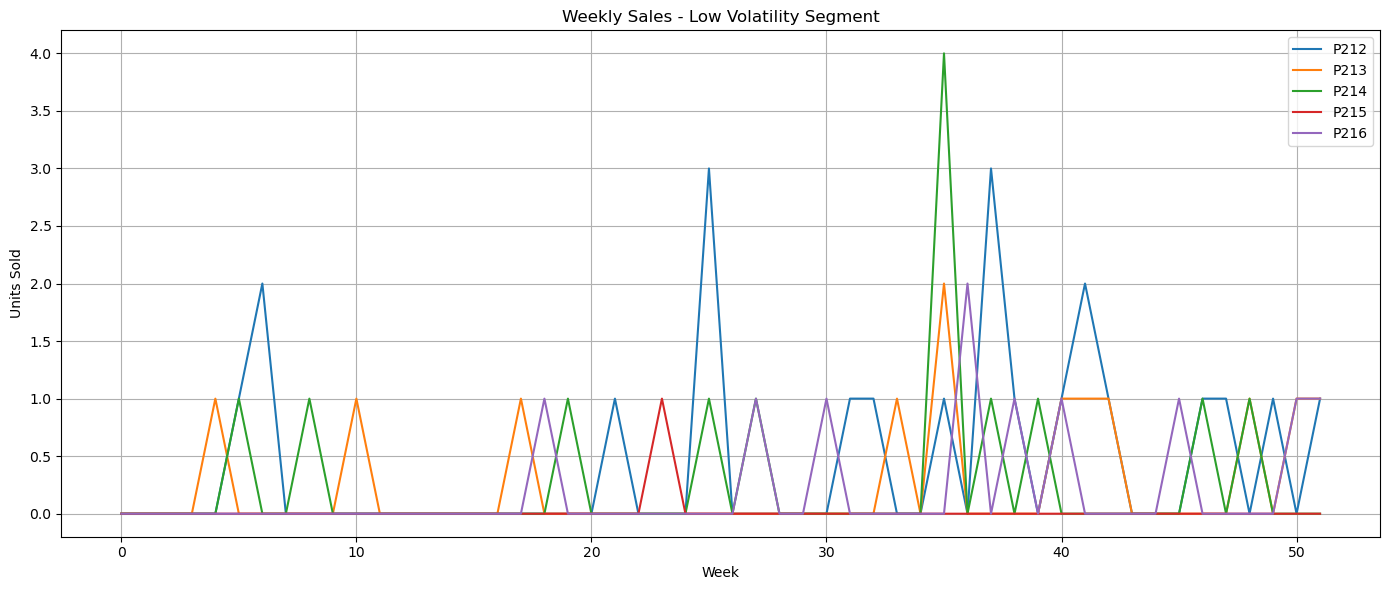

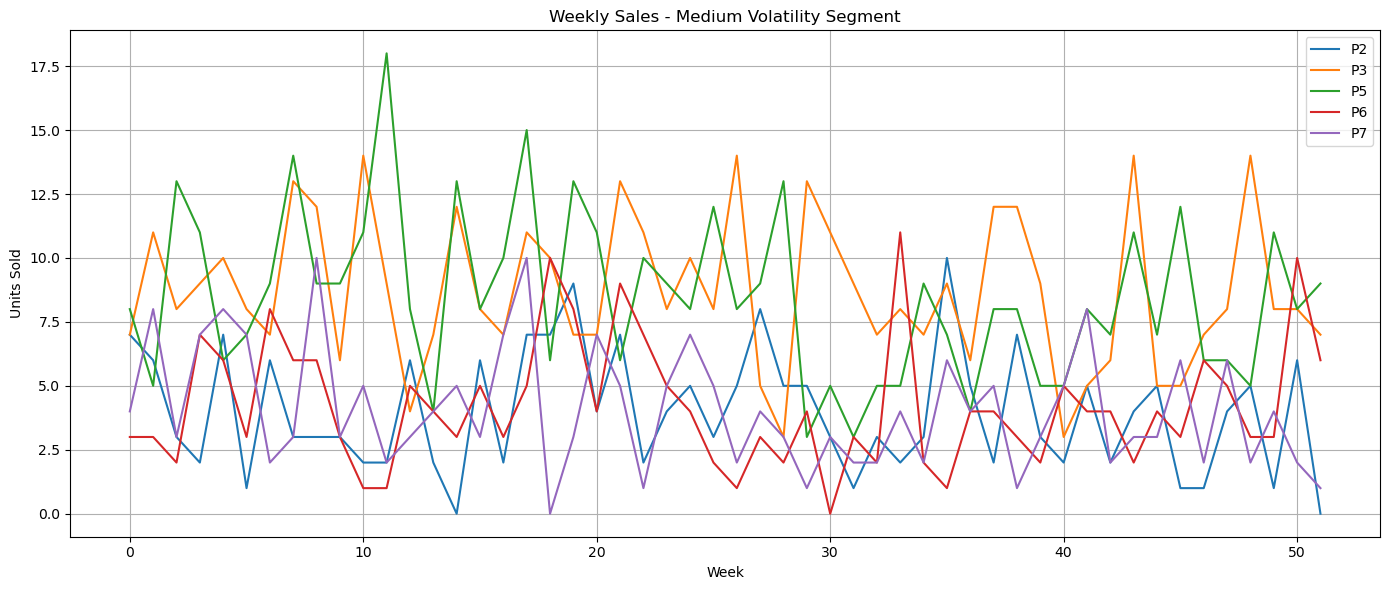

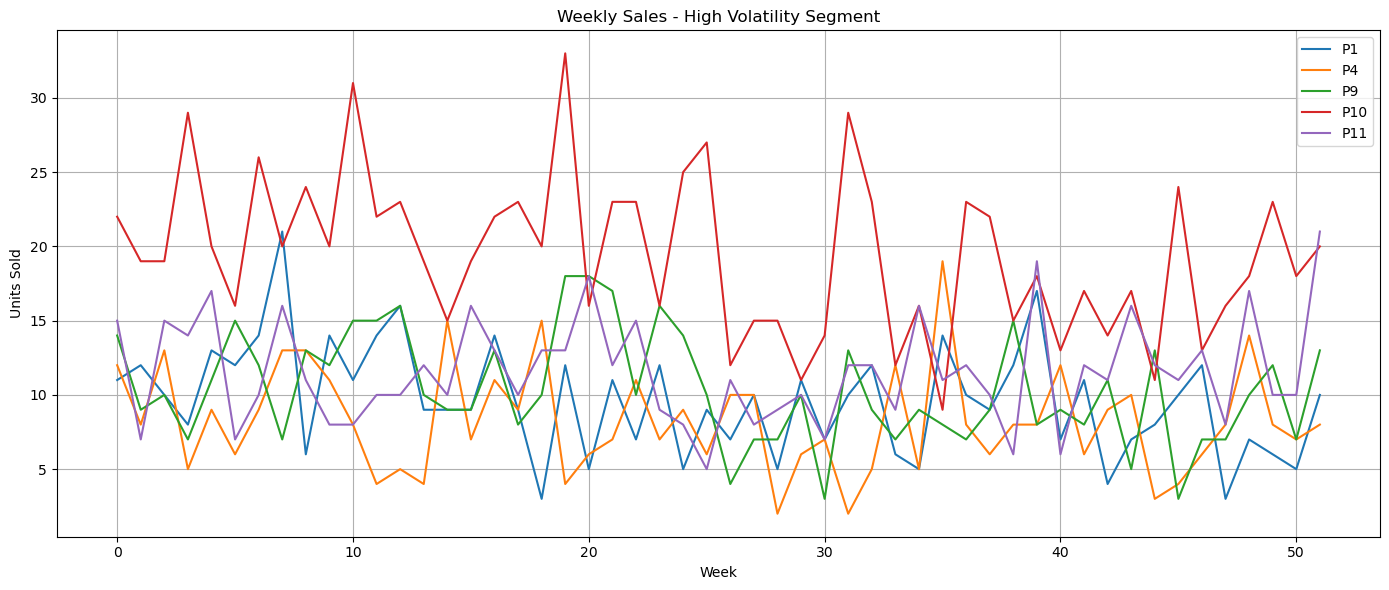

In [43]:
import matplotlib.pyplot as plt

# Function to plot sales for one product
def plot_product_sales(df, product_code):
    product_row = df[df['Product_Code'] == product_code]
    if product_row.empty:
        print(f"Product {product_code} not found.")
        return
    sales = product_row[weekly_columns].values.flatten()
    plt.figure(figsize=(10, 4))
    plt.plot(range(len(sales)), sales, marker='o')
    plt.title(f"Weekly Sales for {product_code}")
    plt.xlabel("Week")
    plt.ylabel("Units Sold")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Function to plot multiple products by volatility
def plot_segment_timeseries(df, segment, n=5):
    sample = df[df['Volatility_Segment'] == segment].head(n)
    plt.figure(figsize=(14, 6))
    for _, row in sample.iterrows():
        plt.plot(range(len(weekly_columns)), row[weekly_columns], label=row['Product_Code'])
    plt.title(f"Weekly Sales - {segment} Volatility Segment")
    plt.xlabel("Week")
    plt.ylabel("Units Sold")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot for each segment
for segment in ['Low', 'Medium', 'High']:
    plot_segment_timeseries(df, segment)

In [44]:
def plot_segment_timeseries(df, segment, n=5):
    sample = df[df['Volatility_Segment'] == segment].head(n)
    
    if sample.empty:
        print(f"⚠️ No products found in the '{segment}' volatility segment.")
        return

    plt.figure(figsize=(14, 6))
    for _, row in sample.iterrows():
        plt.plot(range(len(weekly_columns)), row[weekly_columns], label=row['Product_Code'])

    plt.title(f"Weekly Sales - {segment} Volatility Segment")
    plt.xlabel("Week")
    plt.ylabel("Units Sold")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## Feature Engineering

In [48]:
# Load your dataset
df = pd.read_csv("Sales_Transactions_Dataset_Weekly.csv")
weekly_columns = [col for col in df.columns if col.startswith('W')]

# Select a single product (e.g. P1) for time series modeling
product_code = 'P1'
product_series = df[df['Product_Code'] == product_code][weekly_columns].T
product_series.columns = ['sales']
product_series['week'] = range(len(product_series))

# Add lag features
product_series['lag_1'] = product_series['sales'].shift(1)
product_series['lag_2'] = product_series['sales'].shift(2)

# Add rolling statistics
product_series['roll_mean_3'] = product_series['sales'].rolling(window=3).mean()
product_series['roll_std_3'] = product_series['sales'].rolling(window=3).std()
product_series['roll_max_3'] = product_series['sales'].rolling(window=3).max()
product_series['roll_min_3'] = product_series['sales'].rolling(window=3).min()

# Add time index features (optional)
product_series['week_of_year'] = product_series['week'] % 52

# Drop rows with NaN from lagging/rolling
data = product_series.dropna().reset_index(drop=True)

# Final preview
print(data.head())

   sales  week  lag_1  lag_2  roll_mean_3  roll_std_3  roll_max_3  roll_min_3  \
0     10     2   12.0   11.0    11.000000    1.000000        12.0        10.0   
1      8     3   10.0   12.0    10.000000    2.000000        12.0         8.0   
2     13     4    8.0   10.0    10.333333    2.516611        13.0         8.0   
3     12     5   13.0    8.0    11.000000    2.645751        13.0         8.0   
4     14     6   12.0   13.0    13.000000    1.000000        14.0        12.0   

   week_of_year  
0             2  
1             3  
2             4  
3             5  
4             6  


### What These Features Do:
#### Feature	Purpose
#### lag_1	Captures autoregressive behavior
#### roll_mean_3	Captures short-term trends
#### roll_std_3	Captures short-term volatility
#### week_of_year	Helps model seasonality or cycles

### Lets implement XGBoost

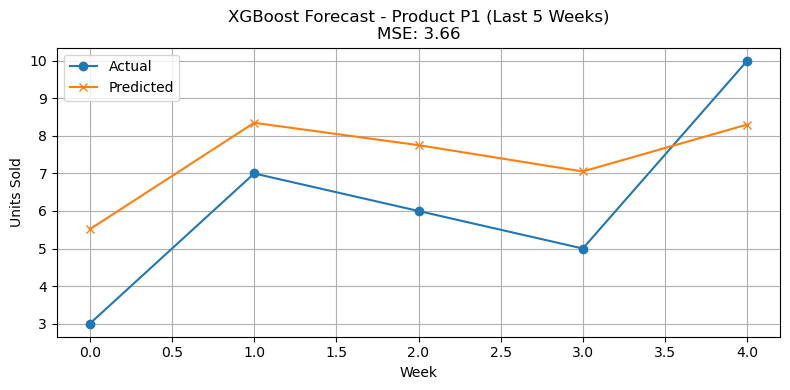

In [52]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# --- Split into Train and Test Sets ---
train = data[:-5]  # All but last 5 weeks
test = data[-5:]   # Last 5 weeks

# --- Define Features and Target ---
features = ['lag_1', 'lag_2', 'roll_mean_3', 'roll_std_3', 'week_of_year']
X_train = train[features]
y_train = train['sales']
X_test = test[features]
y_test = test['sales']

# --- Train XGBoost Model ---
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=20,
    max_depth=3,
    verbosity=0
)
model.fit(X_train, y_train)

# --- Make Predictions ---
y_pred = model.predict(X_test)

# --- Evaluate and Plot ---
mse = mean_squared_error(y_test, y_pred)
plt.figure(figsize=(8, 4))
plt.plot(range(len(y_test)), y_test.values, marker='o', label='Actual')
plt.plot(range(len(y_pred)), y_pred, marker='x', label='Predicted')
plt.title(f'XGBoost Forecast - Product {product_code} (Last 5 Weeks)\nMSE: {mse:.2f}')
plt.xlabel('Week')
plt.ylabel('Units Sold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Evaluate Performance Matrix

In [55]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

import numpy as np

# MSE and RMSE
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# MAE
mae = mean_absolute_error(y_test, y_pred)

# MAPE (handle zero sales safely)
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / np.maximum(y_true, 1))) * 100

mape = mean_absolute_percentage_error(y_test, y_pred)

# Print metrics
print("📊 XGBoost Performance Metrics")
print(f"➡️  MSE:  {mse:.2f}")
print(f"➡️  RMSE: {rmse:.2f}")
print(f"➡️  MAE:  {mae:.2f}")
print(f"➡️  MAPE: {mape:.2f}%")

📊 XGBoost Performance Metrics
➡️  MSE:  3.66
➡️  RMSE: 1.91
➡️  MAE:  1.87
➡️  MAPE: 38.07%


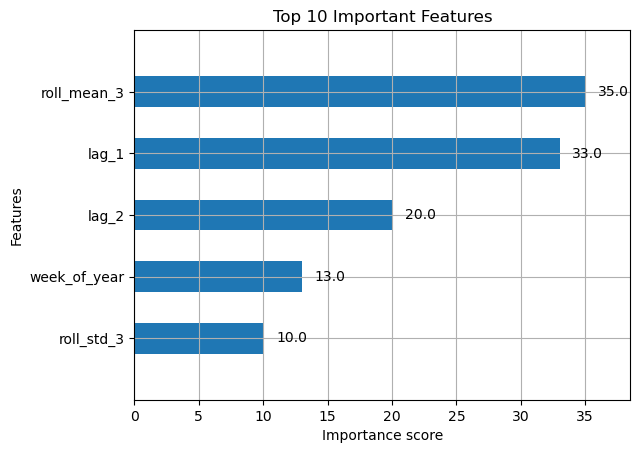

In [57]:
from xgboost import plot_importance
plot_importance(model, height=0.5, max_num_features=10)
plt.title('Top 10 Important Features')
plt.show()

### Forecast next 10 weeks.

C:\Users\npate\AppData\Local\Temp\ipykernel_19472\930102364.py:46: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  next_week = int(last_row['week']) + 1
C:\Users\npate\AppData\Local\Temp\ipykernel_19472\930102364.py:46: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  next_week = int(last_row['week']) + 1
C:\Users\npate\AppData\Local\Temp\ipykernel_19472\930102364.py:46: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  next_week = int(last_row['week']) + 1
C:\Users\npate\AppData\Local\Temp\ipykernel_19472\930102364.py:46: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  next_week = int(last_row['week']) + 1
C:\Users\npate\A

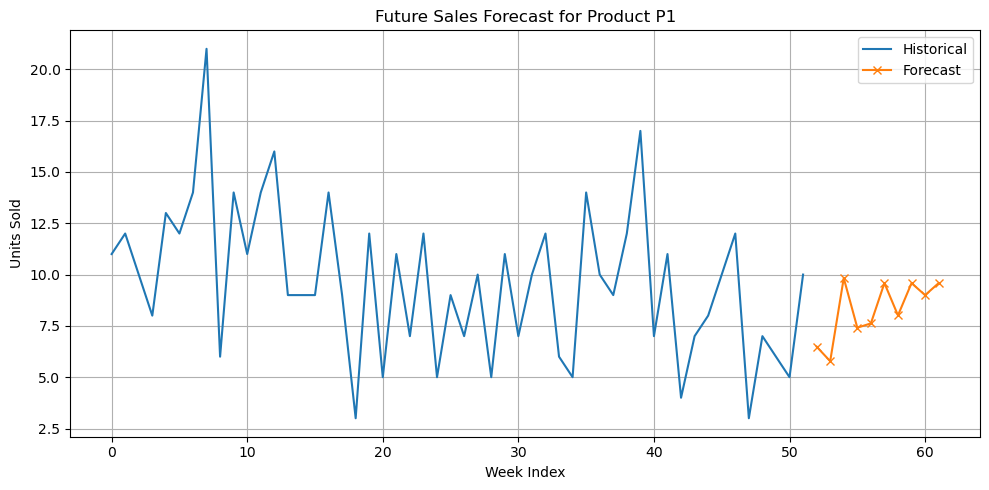

In [60]:
import numpy as np

# Set seed for reproducibility
np.random.seed(42)

# Load dataset
#df = pd.read_csv("Sales_Transactions_Dataset_Weekly.csv")
#weekly_columns = [col for col in df.columns if col.startswith('W']

product_code = 'P1'
product_series = df[df['Product_Code'] == product_code][weekly_columns].T
product_series.columns = ['sales']
product_series['week'] = range(len(product_series))

# Feature Engineering
product_series['lag_1'] = product_series['sales'].shift(1)
product_series['lag_2'] = product_series['sales'].shift(2)
product_series['roll_mean_3'] = product_series['sales'].rolling(window=3).mean()
product_series['roll_std_3'] = product_series['sales'].rolling(window=3).std()
product_series['week_of_year'] = product_series['week'] % 52
data = product_series.dropna().reset_index(drop=True)

# Prepare training data
features = ['lag_1', 'lag_2', 'roll_mean_3', 'roll_std_3', 'week_of_year']
X_train = data[features]
y_train = data['sales']

# Train model
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=20,
    max_depth=3,
    verbosity=0,
    random_state=42
)
model.fit(X_train, y_train)

# Recursive forecast
future_steps = 10
forecast_data = data.copy()
predictions = []

for i in range(future_steps):
    last_row = forecast_data.iloc[-1:]
    
    next_week = int(last_row['week']) + 1
    week_of_year = next_week % 52
    lag_1 = last_row['sales'].values[0]
    lag_2 = forecast_data.iloc[-2]['sales'] if len(forecast_data) >= 2 else lag_1
    roll = forecast_data['sales'].iloc[-3:].rolling(window=3).agg(['mean', 'std']).iloc[-1]
    
    new_features = {
        'lag_1': lag_1,
        'lag_2': lag_2,
        'roll_mean_3': roll['mean'],
        'roll_std_3': roll['std'],
        'week_of_year': week_of_year
    }
    
    X_new = pd.DataFrame([new_features])
    pred = model.predict(X_new)[0]
    predictions.append(pred)
    
    # Append to forecast_data
    new_row = {
        'sales': pred,
        'week': next_week,
        **new_features
    }
    forecast_data = pd.concat([forecast_data, pd.DataFrame([new_row])], ignore_index=True)

# Plot historical + future forecast
plt.figure(figsize=(10, 5))
plt.plot(product_series['sales'].values, label='Historical')
plt.plot(range(len(product_series), len(product_series)+future_steps), predictions, marker='x', label='Forecast')
plt.title(f'Future Sales Forecast for Product {product_code}')
plt.xlabel('Week Index')
plt.ylabel('Units Sold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [62]:
# Load dataset
#df = pd.read_csv("Sales_Transactions_Dataset_Weekly.csv")
#weekly_columns = [col for col in df.columns if col.startswith('W')]

# Set reproducibility
np.random.seed(42)

# Pick first 5 products
selected_products = df['Product_Code'].head(5).tolist()

# Where we store results
forecast_results = []

# Loop over each product
for product_code in selected_products:
    product_series = df[df['Product_Code'] == product_code][weekly_columns].T
    product_series.columns = ['sales']
    product_series['week'] = range(len(product_series))

    # Feature Engineering
    product_series['lag_1'] = product_series['sales'].shift(1)
    product_series['lag_2'] = product_series['sales'].shift(2)
    product_series['roll_mean_3'] = product_series['sales'].rolling(window=3).mean()
    product_series['roll_std_3'] = product_series['sales'].rolling(window=3).std()
    product_series['week_of_year'] = product_series['week'] % 52
    data = product_series.dropna().reset_index(drop=True)

    # Prepare training
    features = ['lag_1', 'lag_2', 'roll_mean_3', 'roll_std_3', 'week_of_year']
    X_train = data[features]
    y_train = data['sales']

    # Train model
    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=20,
        max_depth=3,
        verbosity=0,
        random_state=42
    )
    model.fit(X_train, y_train)

    # Recursive forecasting
    forecast_data = data.copy()
    future_steps = 10
    for i in range(future_steps):
        last_row = forecast_data.iloc[-1:]
        next_week = int(last_row['week']) + 1
        week_of_year = next_week % 52
        lag_1 = last_row['sales'].values[0]
        lag_2 = forecast_data.iloc[-2]['sales'] if len(forecast_data) >= 2 else lag_1
        roll = forecast_data['sales'].iloc[-3:].rolling(window=3).agg(['mean', 'std']).iloc[-1]
        
        new_features = {
            'lag_1': lag_1,
            'lag_2': lag_2,
            'roll_mean_3': roll['mean'],
            'roll_std_3': roll['std'],
            'week_of_year': week_of_year
        }
        X_new = pd.DataFrame([new_features])
        pred = model.predict(X_new)[0]

        forecast_results.append({
            'Product_Code': product_code,
            'Week_Index': next_week,
            'Forecasted_Sales': pred
        })

        # Add new prediction to forecast data
        new_row = {
            'sales': pred,
            'week': next_week,
            **new_features
        }
        forecast_data = pd.concat([forecast_data, pd.DataFrame([new_row])], ignore_index=True)

# Final results as DataFrame
forecast_df = pd.DataFrame(forecast_results)

# Preview
print(forecast_df.head())


C:\Users\npate\AppData\Local\Temp\ipykernel_19472\2949381586.py:48: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  next_week = int(last_row['week']) + 1
C:\Users\npate\AppData\Local\Temp\ipykernel_19472\2949381586.py:48: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  next_week = int(last_row['week']) + 1
C:\Users\npate\AppData\Local\Temp\ipykernel_19472\2949381586.py:48: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  next_week = int(last_row['week']) + 1
C:\Users\npate\AppData\Local\Temp\ipykernel_19472\2949381586.py:48: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  next_week = int(last_row['week']) + 1
C:\Users\npa

  Product_Code  Week_Index  Forecasted_Sales
0           P1          52          6.488709
1           P1          53          5.779336
2           P1          54          9.829036
3           P1          55          7.412222
4           P1          56          7.620501


C:\Users\npate\AppData\Local\Temp\ipykernel_19472\2949381586.py:48: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  next_week = int(last_row['week']) + 1
C:\Users\npate\AppData\Local\Temp\ipykernel_19472\2949381586.py:48: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  next_week = int(last_row['week']) + 1


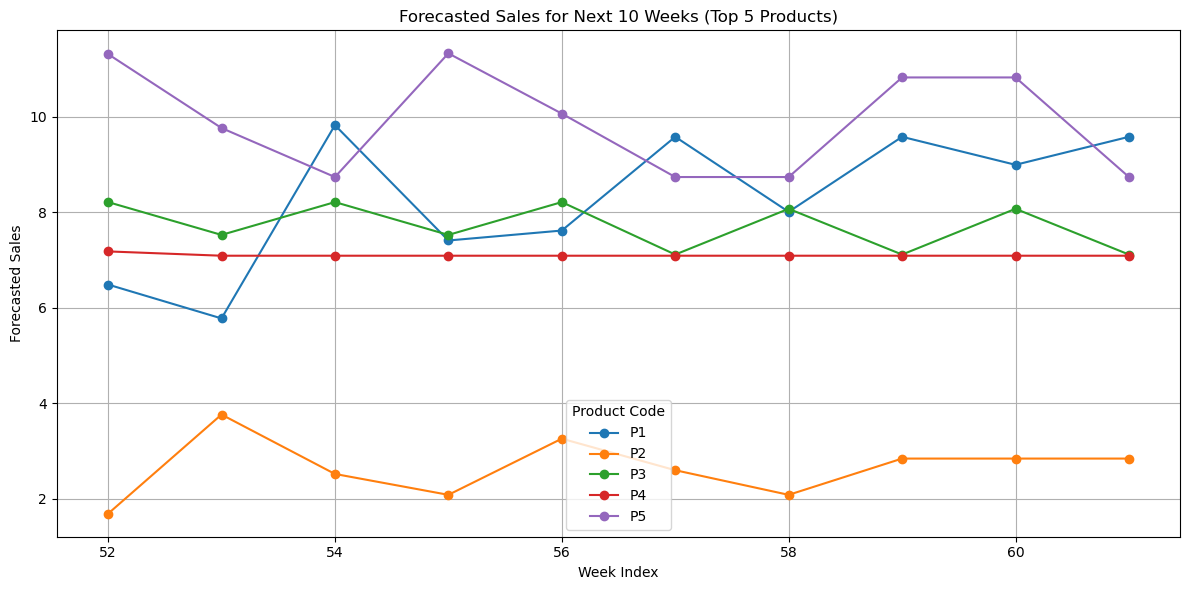

In [64]:
# Group by product and plot each
plt.figure(figsize=(12, 6))
for product_code in forecast_df['Product_Code'].unique():
    product_data = forecast_df[forecast_df['Product_Code'] == product_code]
    plt.plot(product_data['Week_Index'], product_data['Forecasted_Sales'], marker='o', label=product_code)

plt.title("Forecasted Sales for Next 10 Weeks (Top 5 Products)")
plt.xlabel("Week Index")
plt.ylabel("Forecasted Sales")
plt.legend(title="Product Code")
plt.grid(True)
plt.tight_layout()
plt.show()

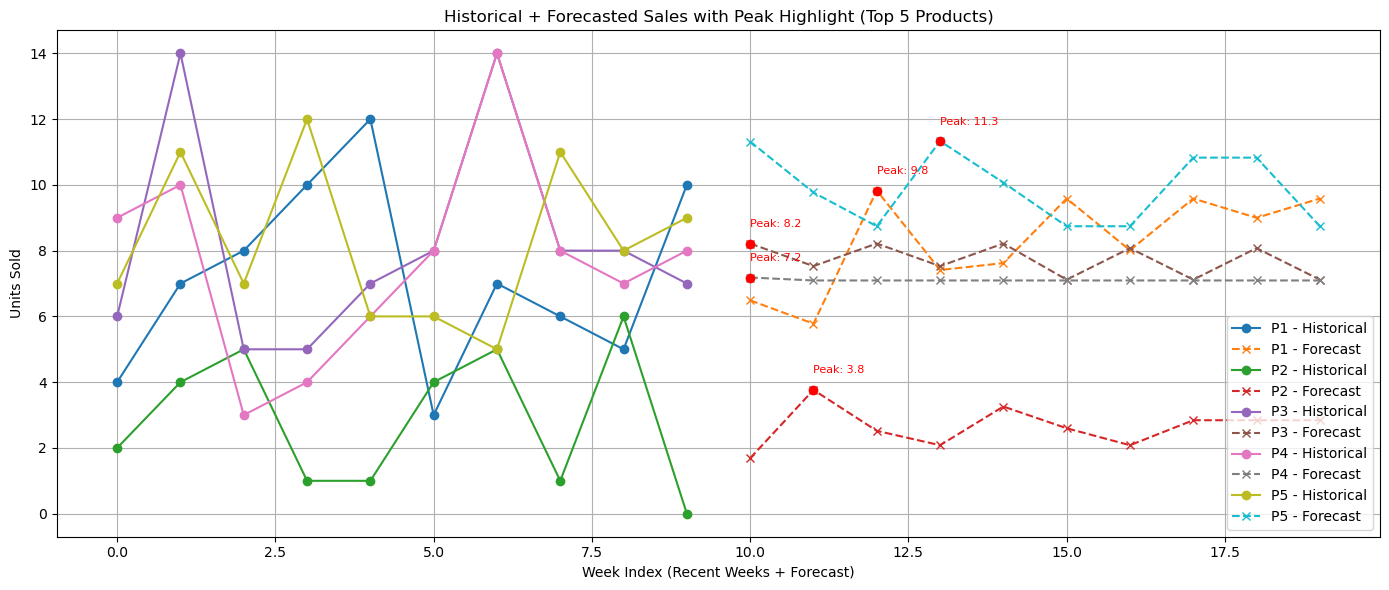

In [66]:
history_weeks = 10

plt.figure(figsize=(14, 6))

for product_code in forecast_df['Product_Code'].unique():
    # Historical sales
    hist_sales = df[df['Product_Code'] == product_code][weekly_columns].T
    hist_sales.columns = ['sales']
    hist_sales = hist_sales.tail(history_weeks).reset_index(drop=True)
    hist_sales['Week_Index'] = range(len(hist_sales))
    
    # Forecasted sales
    product_forecast = forecast_df[forecast_df['Product_Code'] == product_code].copy()
    product_forecast['Week_Index'] = range(len(hist_sales), len(hist_sales) + len(product_forecast))

    # Find peak forecast
    peak_row = product_forecast.loc[product_forecast['Forecasted_Sales'].idxmax()]

    # Plot historical
    plt.plot(hist_sales['Week_Index'], hist_sales['sales'], marker='o', label=f"{product_code} - Historical")

    # Plot forecast
    plt.plot(product_forecast['Week_Index'], product_forecast['Forecasted_Sales'], marker='x', linestyle='--', label=f"{product_code} - Forecast")

    # Highlight peak
    plt.scatter(peak_row['Week_Index'], peak_row['Forecasted_Sales'], color='red', zorder=5)
    plt.text(peak_row['Week_Index'], peak_row['Forecasted_Sales'] + 0.5,
             f"Peak: {peak_row['Forecasted_Sales']:.1f}", color='red', fontsize=8)

plt.title("Historical + Forecasted Sales with Peak Highlight (Top 5 Products)")
plt.xlabel("Week Index (Recent Weeks + Forecast)")
plt.ylabel("Units Sold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

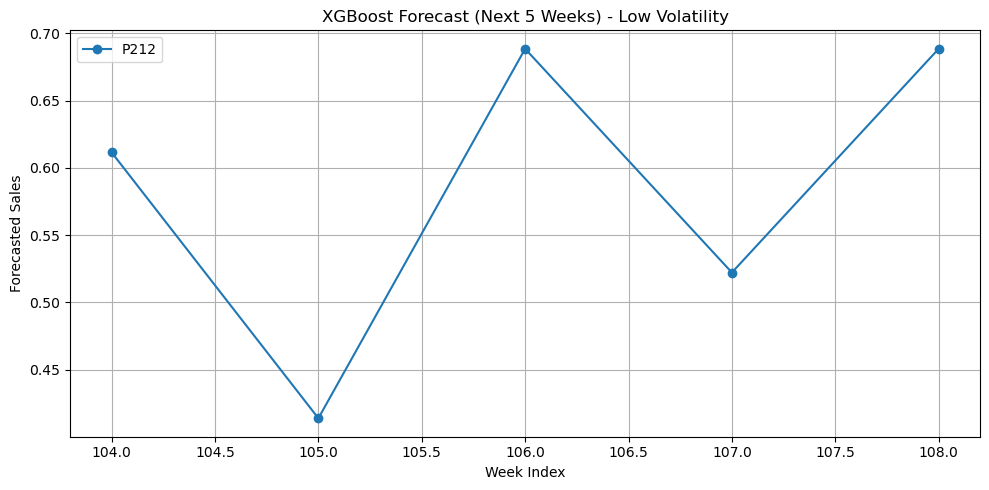

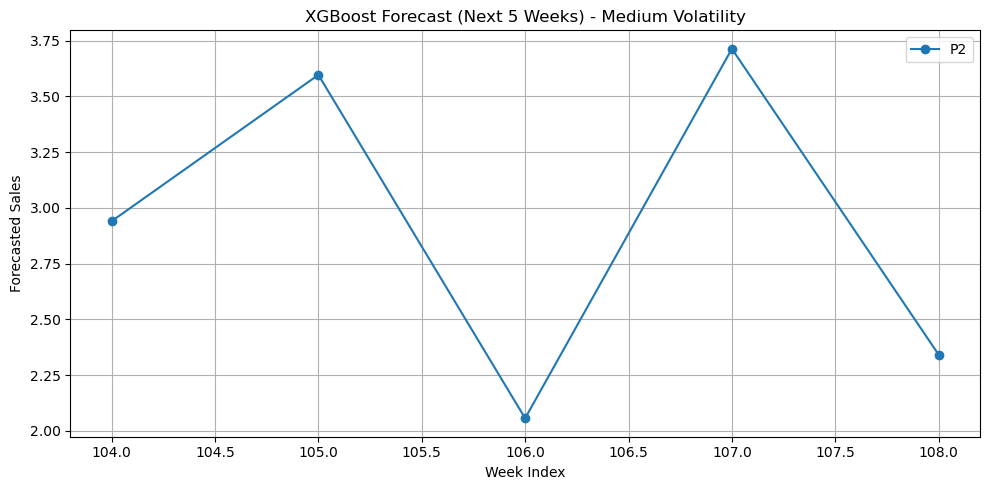

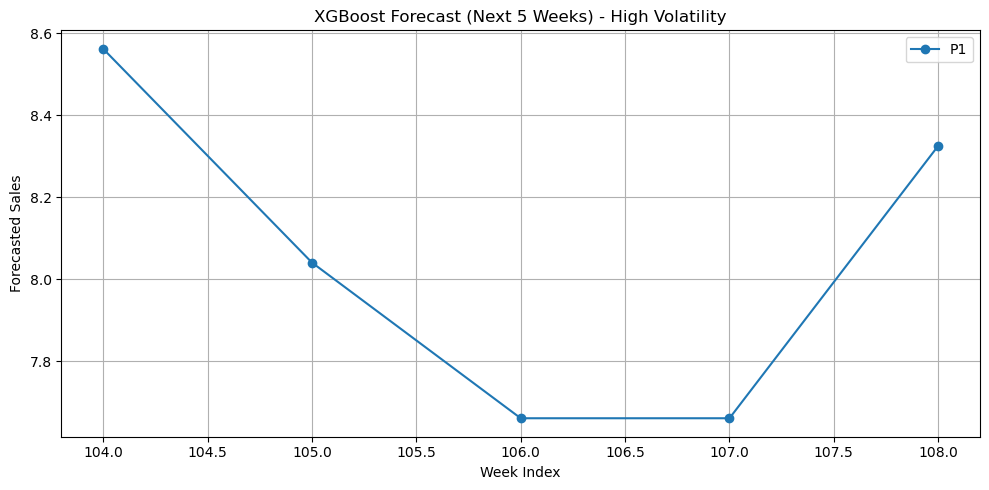

In [68]:
# Compute sales volatility
df['Sales_StdDev'] = df[weekly_columns].std(axis=1)
df['Volatility_Segment'] = pd.qcut(df['Sales_StdDev'], q=3, labels=['Low', 'Medium', 'High'], duplicates='drop')

# Select 1 product from each segment
low_product = df[df['Volatility_Segment'] == 'Low'].head(1)['Product_Code'].values[0]
med_product = df[df['Volatility_Segment'] == 'Medium'].head(1)['Product_Code'].values[0]
high_product = df[df['Volatility_Segment'] == 'High'].head(1)['Product_Code'].values[0]
selected_products = [low_product, med_product, high_product]

# Store forecasts
forecast_results = []

# Forecast using XGBoost
for product_code in selected_products:
    ts = df[df['Product_Code'] == product_code][weekly_columns].T
    ts.columns = ['sales']
    ts['week'] = range(len(ts))
    ts['lag_1'] = ts['sales'].shift(1)
    ts['lag_2'] = ts['sales'].shift(2)
    ts['roll_mean_3'] = ts['sales'].rolling(3).mean()
    ts['roll_std_3'] = ts['sales'].rolling(3).std()
    ts['week_of_year'] = ts['week'] % 52
    ts = ts.dropna().reset_index(drop=True)

    train = ts[:-5]
    test = ts[-5:]
    features = ['lag_1', 'lag_2', 'roll_mean_3', 'roll_std_3', 'week_of_year']
    X_train, y_train = train[features], train['sales']
    X_test = test[features]

    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=10, max_depth=2, verbosity=0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    segment = df[df['Product_Code'] == product_code]['Volatility_Segment'].values[0]
    start_week = df.shape[1] - 5
    for i, pred in enumerate(y_pred):
        forecast_results.append({
            'Product_Code': product_code,
            'Week_Index': start_week + i,
            'Forecasted_Sales': pred,
            'Volatility_Segment': segment
        })

# Convert to DataFrame
forecast_df = pd.DataFrame(forecast_results)

# Plot forecasts
for segment in ['Low', 'Medium', 'High']:
    segment_data = forecast_df[forecast_df['Volatility_Segment'] == segment]
    if segment_data.empty:
        print(f"⚠️ No forecast data for segment: {segment}")
        continue

    plt.figure(figsize=(10, 5))
    for product_code in segment_data['Product_Code'].unique():
        product_data = segment_data[segment_data['Product_Code'] == product_code]
        plt.plot(product_data['Week_Index'], product_data['Forecasted_Sales'], marker='o', label=product_code)

    plt.title(f"XGBoost Forecast (Next 5 Weeks) - {segment} Volatility")
    plt.xlabel("Week Index")
    plt.ylabel("Forecasted Sales")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### Let’s make our forecasting workflow clean, modular, and scalable. We’ll break it down into reusable functions so we can forecast:

#### ✅ Any number of products

#### ✅ For any volatility segment

#### ✅ With consistent feature engineering + XGBoost model

#### ✅ And plot or save results easily

### 1. Setup & Feature Engineering Function

In [1]:
def prepare_product_timeseries(df, product_code, weekly_columns):
    ts = df[df['Product_Code'] == product_code][weekly_columns].T
    ts.columns = ['sales']
    ts['week'] = range(len(ts))
    ts['lag_1'] = ts['sales'].shift(1)
    ts['lag_2'] = ts['sales'].shift(2)
    ts['roll_mean_3'] = ts['sales'].rolling(3).mean()
    ts['roll_std_3'] = ts['sales'].rolling(3).std()
    ts['week_of_year'] = ts['week'] % 52
    return ts.dropna().reset_index(drop=True)

### 2. XGBoost Forecasting Function

In [3]:
def forecast_product(df, product_code, weekly_columns, forecast_weeks=5):
    ts = prepare_product_timeseries(df, product_code, weekly_columns)
    train = ts[:-forecast_weeks]
    test = ts[-forecast_weeks:]
    features = ['lag_1', 'lag_2', 'roll_mean_3', 'roll_std_3', 'week_of_year']
    
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=10, max_depth=2, verbosity=0)
    model.fit(train[features], train['sales'])
    y_pred = model.predict(test[features])
    
    segment = df[df['Product_Code'] == product_code]['Volatility_Segment'].values[0]
    start_week = len(weekly_columns) - forecast_weeks
    
    return pd.DataFrame({
        'Product_Code': product_code,
        'Week_Index': range(start_week, start_week + forecast_weeks),
        'Forecasted_Sales': y_pred,
        'Volatility_Segment': segment
    })

### 3. Forecast Multiple Products by Segment

In [5]:
def forecast_multiple(df, product_codes, weekly_columns, forecast_weeks=5):
    all_forecasts = []
    for code in product_codes:
        try:
            f_df = forecast_product(df, code, weekly_columns, forecast_weeks)
            all_forecasts.append(f_df)
        except Exception as e:
            print(f"Error with {code}: {e}")
    return pd.concat(all_forecasts, ignore_index=True)

### 4. Plot Forecasts by Volatility

In [ ]:
def plot_forecasts_by_volatility(forecast_df):
    for segment in ['Low', 'Medium', 'High']:
        segment_data = forecast_df[forecast_df['Volatility_Segment'] == segment]
        if segment_data.empty:
            print(f"⚠️ No forecast data for segment: {segment}")
            continue

        plt.figure(figsize=(10, 5))
        for product_code in segment_data['Product_Code'].unique():
            product_data = segment_data[segment_data['Product_Code'] == product_code]
            plt.plot(product_data['Week_Index'], product_data['Forecasted_Sales'], marker='o', label=product_code)

        plt.title(f"XGBoost Forecast (Next 5 Weeks) - {segment} Volatility")
        plt.xlabel("Week Index")
        plt.ylabel("Forecasted Sales")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

### 5. Main Execution 

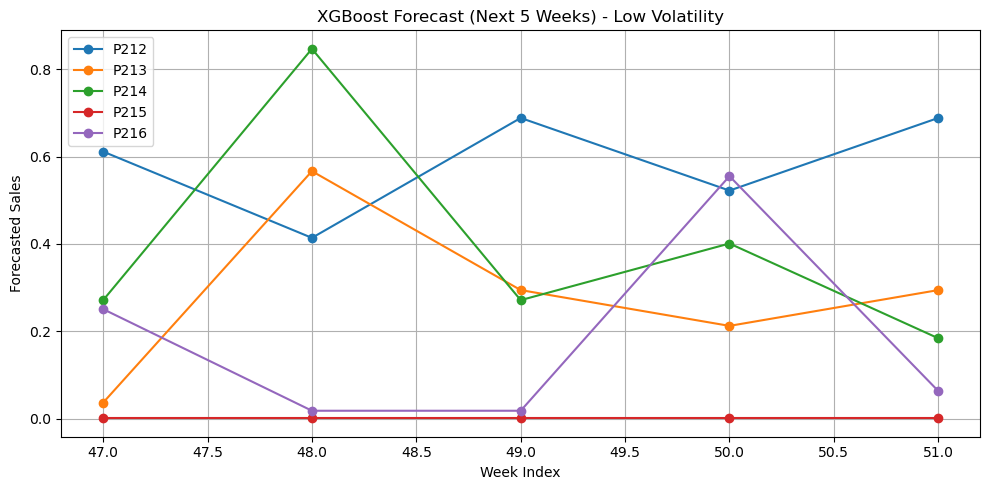

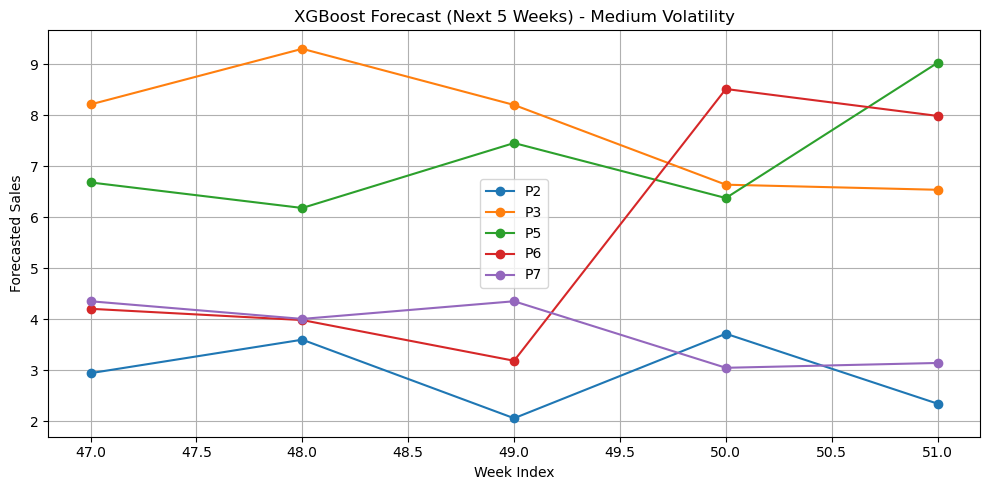

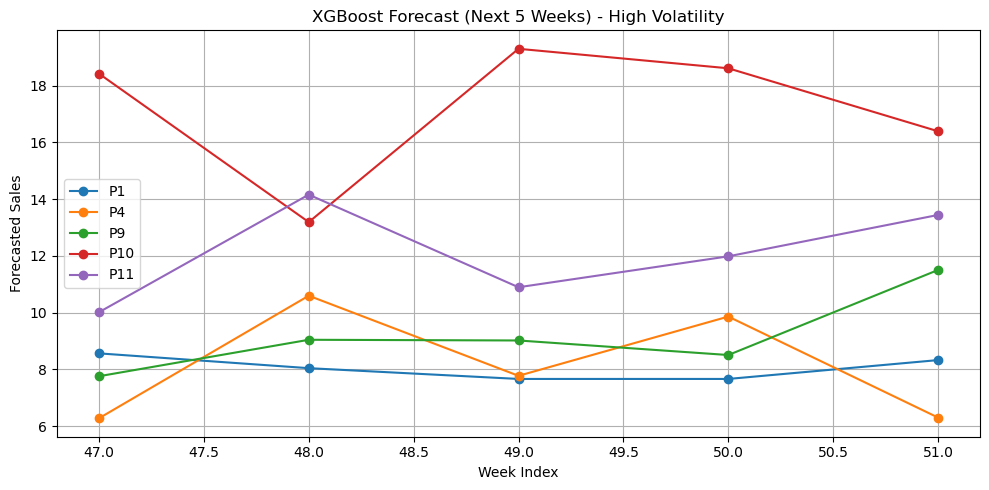

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np

df = pd.read_csv("Sales_Transactions_Dataset_Weekly.csv")
weekly_columns = [col for col in df.columns if col.startswith("W")]
df['Sales_StdDev'] = df[weekly_columns].std(axis=1)
df['Volatility_Segment'] = pd.qcut(df['Sales_StdDev'], q=3, labels=['Low', 'Medium', 'High'], duplicates='drop')

# Choose a few products from each segment
low_products = df[df['Volatility_Segment'] == 'Low'].head(5)['Product_Code'].tolist()
med_products = df[df['Volatility_Segment'] == 'Medium'].head(5)['Product_Code'].tolist()
high_products = df[df['Volatility_Segment'] == 'High'].head(5)['Product_Code'].tolist()
selected_products = low_products + med_products + high_products

# Forecast and plot
forecast_df = forecast_multiple(df, selected_products, weekly_columns)
plot_forecasts_by_volatility(forecast_df)

In [80]:
# Save as CSV
forecast_df.to_csv("xgboost_forecast_results.csv", index=False)
print("✅ Forecast exported successfully.")

✅ Forecast exported successfully.
